## XModalix Port First Milestone: ImageVAE + Loader


### Outcome
- Have a image loader and image VAE
- Train this in a notebook
    - With c. elegans and MNIST images


### Checks
- Check loss curves
- Check image recons
- 


### Steps
- Prepare datasets
    - Maybe already done in 00 notebook
- Prepare config
- Write ImageDataset Class
- Write / port ImageVAE

#### IMPORTS

In [1]:
import os
from autoencodix.utils.default_config import DataConfig, DataInfo, DefaultConfig
import autoencodix as acx

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
print(notebook_dir)
os.chdir(notebook_dir)
os.chdir("..")
print(os.getcwd())


/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/maximilianjoas/development/autoencodix_package/notebooks
/Users/maximilianjoas/development/autoencodix_package


#### GLOBALS


In [2]:
IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config = DefaultConfig(
        checkpoint_interval=1,
        class_param="early",
        epochs=5,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
                translate_direction="to",
            ),
            "RNA": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "RNA2": DataInfo(
                file_path=NUMFILE,
                data_type="NUMERIC",
                translate_direction="from",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    )
)

In [3]:
xmodalix = acx.XModalix(config=img_config)
ds = xmodalix.preprocess()

preprocessing
Checking data type: IMG
Found image type in config
current data info: file_path='data/images/ALY-2_SYS721/' data_type='IMG' scaling='STANDARD' filtering='VAR' sep=None extra_anno_file=None is_single_cell=False min_cells=0.05 min_genes=0.02 selected_layers=['X'] is_X=False normalize_counts=True log_transform=True k_filter=20 img_root=None img_width_resize=64 img_height_resize=64 translate_direction='to'
Checking data type: RNA
Checking data type: RNA2
Checking data type: ANNO
Given image size is possible, rescaling images to: 64x64
reading annotation file: data/ALY-2_SYS721_mappings.txt
 n_samples: {'multi_sc': {'multi_sc': 0}, 'multi_bulk': {'RNA': 260, 'RNA2': 260}, 'annotation': {'paired': 260}, 'img': {'IMG': 260}, 'from_modality': {}, 'to_modality': {}, 'paired_count': {'paired_count': 260}}
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
key: train, type: <class 'dict'

/Users/maximilianjoas/development/autoencodix_package/src/autoencodix/utils/_imgreader.py:251: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  annotation = pd.read_csv(anno_file, sep=sep)


In [4]:
import torch
torch.autograd.set_detect_anomaly(True)
xmodalix.fit()

called init loaders
setup fabric
--- Epoch 1/5 ---
Epoch 1/5 - Train Loss: 74.8699
no common ids
no common ids
Epoch 1/5 - Valid Loss: 15.6629
Storing checkpoint for epoch 0...
--- Epoch 2/5 ---
Epoch 2/5 - Train Loss: 73.1400
Epoch 2/5 - Valid Loss: 15.3702
Storing checkpoint for epoch 1...
--- Epoch 3/5 ---
Epoch 3/5 - Train Loss: 72.0284
Epoch 3/5 - Valid Loss: 15.0220
Storing checkpoint for epoch 2...
--- Epoch 4/5 ---
Epoch 4/5 - Train Loss: 71.3983
no common ids
no common ids
Epoch 4/5 - Valid Loss: 14.9666
Storing checkpoint for epoch 3...
--- Epoch 5/5 ---
Epoch 5/5 - Train Loss: 71.1434
Epoch 5/5 - Valid Loss: 15.3804
Storing checkpoint for epoch 4...


In [5]:
len(xmodalix._trainer._trainloader)

3

In [6]:
result = xmodalix.result

In [7]:
result.sub_losses.get("adver_loss").get()

{0: {'train': array(3.47145792), 'valid': array(0.75828703)},
 1: {'train': array(3.47784452), 'valid': array(0.74653284)},
 2: {'train': array(3.46083144), 'valid': array(0.74120474)},
 3: {'train': array(3.47896667), 'valid': array(0.7278289)},
 4: {'train': array(3.48759286), 'valid': array(0.75970383)}}

In [8]:
img = result.reconstructions.get(split="train", epoch=-1)["img.IMG"]

In [9]:
img.shape

(403, 1, 64, 64)

In [10]:
sample_img = img[0,:,:,:].squeeze()
sample_img.shape

(64, 64)

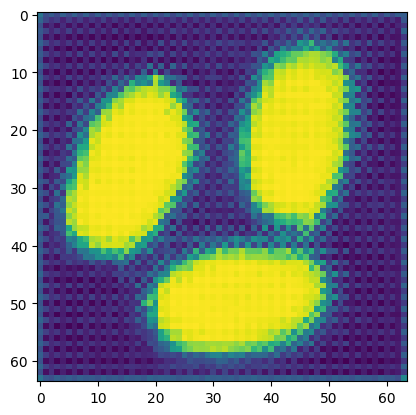

In [11]:
import matplotlib.pyplot as plt
plt.imshow(sample_img)

## Xmodal_loss

In [12]:
loss_cl = xmodalix._trainer._loss_fn
batch_dynamics = xmodalix._trainer._modality_dynamics
batch = next(iter(xmodalix._trainer._trainloader))
config = img_config
print(config.loss_reduction)

mean


In [13]:
# img_config.class_param = "early"
for mod_name, mod_data in batch.items():
    metadata_df = mod_data.get("metadata")



In [15]:
  def _calc_class_loss(
        self,
        batch: Dict[str, Dict[str, Any]],
        modality_dynamics: Dict[str, Dict[str, Any]],
    ) -> torch.Tensor:
        
        device = next(iter(modality_dynamics.values()))["mp"].latentspace.device

        if not self.class_param:
            return torch.tensor(0.0, device=device)

        # Step 1: Dynamically update maps and discover new classes from the batch
        for mod_name, mod_data in batch.items():
            metadata_df = mod_data.get("metadata")
            if metadata_df is None:
                continue

            batch_map = metadata_df[self.class_param]
            self.sample_to_class_map.update(batch_map.to_dict())

            for label in batch_map.unique():
                if label not in self.class_means:
                    self.class_means[label] = torch.zeros(self.latent_dim, device=device)

        # Step 2: Calculate the loss for the current batch
        total_class_loss = torch.tensor(0.0, device=device)
        for mod_name, mod_data in batch.items():
            if mod_data.get("metadata") is None:
                continue
                
            latents = modality_dynamics[mod_name]["mp"].latentspace
            metadata_df = mod_data["metadata"]
            batch_class_labels = metadata_df[self.class_param].tolist()

            target_means_list = [self.class_means[label] for label in batch_class_labels]
            target_means_tensor = torch.stack(target_means_list).to(latents.device)
            
            distance = torch.abs(latents - target_means_tensor).mean(dim=1)
            total_class_loss += self.reduction_fn(distance)

        num_modalities_in_batch = len(batch)
        return total_class_loss / num_modalities_in_batch if num_modalities_in_batch > 0 else total_class_loss

    def update_class_means(self, epoch_dynamics: List[Dict], device):
        """
        Method to be called by the Trainer at the end of an epoch to update the
        target class mean vectors.
        """
        if not self.class_param or not epoch_dynamics:
            return

        final_latents = defaultdict(list)
        final_sample_ids = defaultdict(list)
        for batch_data in epoch_dynamics:
            for mod_name, data in batch_data["latentspaces"].items():
                final_latents[mod_name].append(data)
            for mod_name, data in batch_data["sample_ids"].items():
                final_sample_ids[mod_name].append(data)

        all_latents_df_list = []
        for mod_name in final_latents.keys():
            mod_latents = np.concatenate(final_latents[mod_name])
            mod_ids = np.concatenate(final_sample_ids[mod_name])
            all_latents_df_list.append(pd.DataFrame(mod_latents, index=mod_ids))

        if not all_latents_df_list:
            return

        all_latents_df = pd.concat(all_latents_df_list)
        all_latents_df["class_label"] = all_latents_df.index.map(self.sample_to_class_map)

        new_means_df = all_latents_df.groupby("class_label").mean()

        for label, mean_values in new_means_df.iterrows():
            self.class_means[label] = torch.tensor(
                mean_values.values, dtype=torch.float32, device=device
            )

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 44)

In [ ]:
metadata_df

```python
sample_ids = {}

for k,v in batch.items():

    print(v.keys())

sample_ids



output

sample_ids = {}

for k,v in batch.items():

    print(v.keys())

sample_ids



with metadata lookin like

batch["multi_bulk.RNA"]["metadata"]```

In [ ]:
latenspaces = {}
for k, v in batch_dynamics.items():
    latenspaces[k] = v["mp"].latentspace.detach()
    # latenspaces[k] = v["la"]
latenspaces

In [ ]:
batch["multi_bulk.RNA"]["metadata"].head()

In [ ]:
sample_ids = {}
for k,v in batch.items():
    print(v.keys())
sample_ids

In [ ]:
from typing import Dict, Any

import torch
import itertools
from collections import defaultdict

def calculate_paired_loss(
    latentspaces: dict[str, torch.Tensor],
    sample_ids: dict[str, list],
    reduction: str = "mean",
    device: str = "mps"
) -> torch.Tensor:
    """
    Calculates the paired distance loss across all pairs of modalities in a batch.

    Args:
        latentspaces: A dictionary mapping modality names to their latent space tensors.
                      e.g., {'RNA': tensor_rna, 'ATAC': tensor_atac}
        sample_ids: A dictionary mapping modality names to their list of sample IDs.
        reduction: The type of reduction to apply ('mean' or 'sum').

    Returns:
        A single scalar tensor representing the total paired loss.
    """
    
    total_paired_loss = torch.tensor(0.0, device=device)
    modality_names = list(latentspaces.keys())
    
    # 1. Iterate through all unique pairs of modalities
    for mod_a, mod_b in itertools.combinations(modality_names, 2):
        
        ids_a = sample_ids[mod_a]
        ids_b = sample_ids[mod_b]
        
        # 2. Find the intersection of sample IDs
        common_ids = set(ids_a) & set(ids_b)
        
        if not common_ids:
            print("no common ids")
            continue # No overlapping samples for this pair, skip
            
        # 3. Create a mapping from sample ID to index for efficient lookup
        id_to_idx_a = {sample_id: i for i, sample_id in enumerate(ids_a)}
        id_to_idx_b = {sample_id: i for i, sample_id in enumerate(ids_b)}
        
        # Get the corresponding indices for the common samples
        indices_a = [id_to_idx_a[common_id] for common_id in common_ids]
        indices_b = [id_to_idx_b[common_id] for common_id in common_ids]
        
        # 4. Select the latent vectors for the paired samples
        paired_latents_a = latentspaces[mod_a][indices_a]
        paired_latents_b = latentspaces[mod_b][indices_b]
        
        # 5. Calculate the distance between the aligned latent vectors
        # L1 distance, averaged over latent dimensions and then over samples
        distance = torch.abs(paired_latents_a - paired_latents_b).mean(dim=1)
        
        if reduction == 'mean':
            pair_loss = distance.mean()
        elif reduction == 'sum':
            pair_loss = distance.sum()
        else:
            raise ValueError(f"Reduction must be 'mean' or 'sum', not {reduction}")
            
        # 6. Aggregate the loss
        total_paired_loss += pair_loss
        
    return total_paired_loss
    

In [ ]:
calculate_paired_loss(latentspaces=latenspaces, sample_ids=sample_ids)

## Imagix
If we want to use a standard image vae, we can use the Imagix pipeline. Note that only one image dataset is allowed here
**NOTE**:
set the datacase in config to DataCase.IMG_TO_IMG

In [ ]:
import autoencodix as acx
from autoencodix.utils.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)
import os

IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
NUMFILE = os.path.join("data/AM3_NO2_raw_cell.tsv")

img_config2 = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=img_config2)
imagix.preprocess()
imagix.fit()

In [ ]:
imagix.predict()

In [ ]:
r = imagix.result
r.final_reconstruction
sample_img = r.final_reconstruction.data[0, :, :, :]
sample_img = sample_img.squeeze()

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(sample_img.numpy())

### Old, maybe reuse code for getting stats, but seemd to work

In [ ]:
# Simple statistics tracking - just build the dict in your training loop

# Initialize stats dict once before training
stats = {}
for modality in trainset.datasets.keys():
    stats[modality] = {}
    for sample_id in trainset.datasets[modality].sample_ids:
        stats[modality][sample_id] = 0
print(stats)
# Training loop
epochs = 100

# Add this to your training loop
for epoch in range(100):  # Just test first 5 epochs
    batch_count = 0
    for batch_idx, batch in enumerate(dataloader):
        batch_count += 1

    print(f"Epoch {epoch}: {batch_count} batches processed")

    # Also check sampler length
    print(f"Sampler length: {len(sampler)}")
    print(f"Dataset length: {len(trainset)}")
    print(f"Paired samples: {len(trainset.paired_sample_ids)}")
    print(f"Unpaired samples: {len(trainset.unpaired_sample_ids)}")
    # # Reset stats for new epoch
    # for modality in stats:
    #     for sample_id in stats[modality]:
    #         stats[modality][sample_id] = 0

    for batch_idx, batch in enumerate(dataloader):
        # Update stats with current batch
        for modality, data in batch.items():
            if "sample_ids" in data:
                for sample_id in data["sample_ids"]:
                    if sample_id in stats[modality]:
                        stats[modality][sample_id] += 1

        # Your training code here
        # for modality, data in batch.items():
        #     if data["data"] is not None:
        #         outputs = models[modality](data["data"])

    # Print simple summary at end of epoch
    print("\nSampling Stats:")
    for modality in stats:
        counts = list(stats[modality].values())
        seen = sum(1 for c in counts if c > 0)
        total = len(counts)
        avg = sum(counts) / len(counts) if counts else 0
        print(f"  {modality}: {seen}/{total} samples seen, avg: {avg:.2f}")

    # Optional: Print unseen samples
    print("\nUnseen samples:")
    for modality in stats:
        unseen = [sid for sid, count in stats[modality].items() if count == 0]
        if unseen:
            print(
                f"  {modality}: {len(unseen)} unseen - {unseen[:5]}{'...' if len(unseen) > 5 else ''}"
            )

# Access raw stats anytime:
# stats = {
#     "img.IMG": {"T_98": 3, "T_138": 2, "T_183": 1, ...},
#     "multi_bulk.RNA": {"T_98": 4, "T_138": 3, "T_173": 2, ...},
#     ...
# }